In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

In [266]:
def generate_dataset():
    centers = [(0, 0), (2.5, 5), (5, 0)]
    cluster_std = [0.5, 0.6, 0.7]
    n_samples = np.random.randint(40, 60)
    return make_blobs(n_samples=n_samples, cluster_std=cluster_std,
                      centers=centers, n_features=2, random_state=None)

def show(X, y=None):
    if y is None:
        plt.scatter(X[:, 0], X[:, 1])
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

In [267]:
def dist(x1, x2):
    return np.linalg.norm(x1 - x2)

def distances(X):
    n = X.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            d = dist(X[i], X[j])
            D[i, j] = d
            D[j, i] = d
    return D

def find_min(D):
    n = D.shape[0]
    d = np.inf
    min_i, min_j = -1, -1
    for i in range(n):
        for j in range(i + 1, n):
            if D[i, j] < d:
                d = D[i, j]
                min_i, min_j = i, j
    return min_i, min_j

def find_max(D):
    n = D.shape[0]
    d = -np.inf
    max_i, max_j = -1, -1
    for i in range(n):
        for j in range(i + 1, n):
            if D[i, j] > d:
                d = D[i, j]
                max_i, max_j = i, j
    return max_i, max_j

# 1. Алгоритм Кратчайшего наименьшего пути

In [268]:
def neighbors(A, node):
    return np.where(A[node] == 1)[0]

def dfs(A, node, y, c, visited=None):
    if visited is None:
        visited = set()
    stack = [int(node)]
    while stack:
        v = stack.pop()
        if v in visited:
            continue
        visited.add(v)
        y[v] = c
        for w in neighbors(A, v):
            if w not in visited:
                stack.append(int(w))

In [269]:
def attach_isolated(D, attached):
    n = D.shape[0]
    isolated = ~attached
    min_d = np.inf
    min_i = -1
    min_j = -1
    for i in range(n):
        if attached[i]:
            continue
        for j in range(n):
            if not attached[j]:
                continue
            if min_d > D[i, j]:
                min_d = D[i, j]
                min_i, min_j = i, j
    return min_i, min_j

def build_tree(D):
    n = D.shape[0]
    A = np.zeros((n, n), dtype=int)

    i, j = find_min(D)
    A[i, j] = A[j, i] = 1

    attached = np.zeros(n, dtype=bool)
    attached[i] = attached[j] = True

    for _ in range(n - 2):
        i, j = attach_isolated(D, attached)
        A[i, j] = A[j, i] = 1
        attached[i] = True

    return A

def cut_longest(A, D, k):
    n = A.shape[0]
    edges = []
    for i in range(n):
        for j in range(i + 1, n):
            if A[i, j] == 1:
                edges.append((D[i, j], i, j))
    edges.sort()
    m = k - 1
    for t in range(1, m + 1):
        d, i, j = edges[-t]
        A[i, j] = 0
        A[j, i] = 0
    return A

def label_components(A):
    n = A.shape[0]
    y = -np.ones(n, dtype=int)
    c = 0
    for v in range(n):
        if y[v] == -1:
            dfs(A, v, y, c)
            c += 1
    return y

def separate(X, k):
    D = distances(X)
    A = build_tree(D)
    A = cut_longest(A, D, k)
    y = label_components(A)
    return y


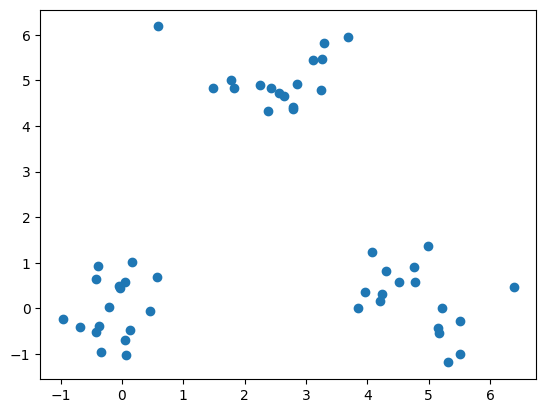

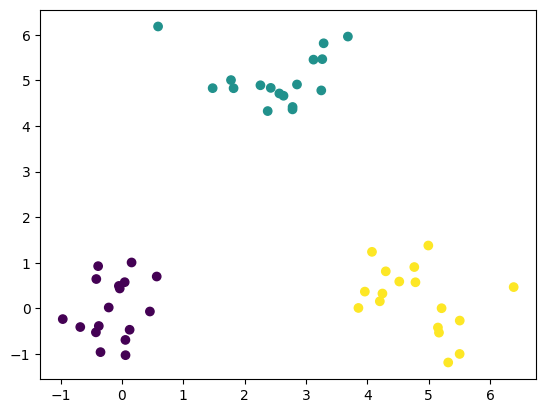

In [270]:
X, y = generate_dataset()
show(X)

y_predicted = separate(X, 3)
show(X, y_predicted)

# 2. Алгоритм максиминного расстояния

In [239]:
def find_min(D, x0, forbidden):
    d = np.inf
    min_j = -1
    for j in range(D.shape[1]):
        if forbidden[j]:
            continue
        if D[x0, j] < d:
            d = D[x0, j]
            min_j = j
    return min_j

def find_max(D, x0, forbidden):
    d = -np.inf
    max_j = -1
    for j in range(D.shape[1]):
        if forbidden[j]:
            continue
        if D[x0, j] > d:
            d = D[x0, j]
            max_j = j
    return max_j

In [264]:
def find_clusters(D, first_center):
    n = D.shape[0]
    y = -np.ones(n, dtype=int)
    centers = np.zeros(n, dtype=bool)

    y[first_center] = 0
    centers[first_center] = True

    second_center = find_max(D, first_center, centers)
    centers[second_center] = True
    y[second_center] = 1
    cluster_num = 2

    for _ in range(n):
        best_p = -1
        best_d = -np.inf
        for p in range(n):
            if centers[p]:
                continue

            dmin = np.inf
            for i in range(n):
                if centers[i]:
                    if D[p, i] < dmin:
                        dmin = D[p, i]

            if dmin > best_d:
                best_d = dmin
                best_p = p

        inter_centre_min = np.inf
        center_ids = np.where(centers)[0]
        for a in range(len(center_ids)):
            for b in range(a + 1, len(center_ids)):
                i, j = center_ids[a], center_ids[b]
                if D[i, j] < inter_centre_min:
                    inter_centre_min = D[i, j]

        if best_d < inter_centre_min / 2:
            break

        centers[best_p] = True
        y[best_p] = cluster_num
        cluster_num += 1

    for not_centre in range(n):
        if centers[not_centre]:
            continue
        center = find_min(D, not_centre, ~centers)
        y[not_centre] = y[center]

    return y


def separate(X, x0=0):
    D = distances(X)
    return find_clusters(D, x0)


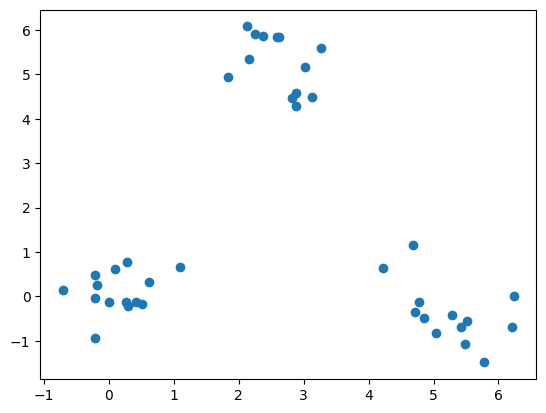

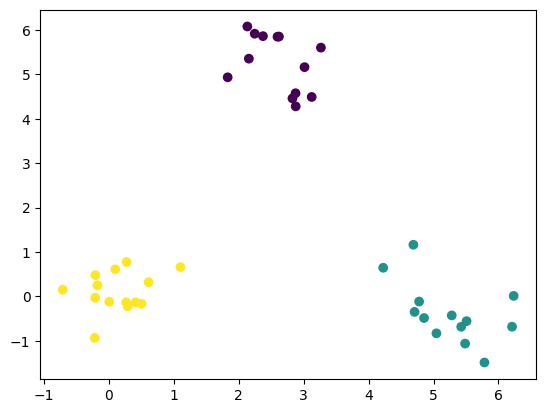

In [265]:
X, y = generate_dataset()
show(X)

y_predicted = separate(X, 0)
show(X, y_predicted)